<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/changepoint_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import NUTS, MCMC
from pyro.optim import Adam
import pandas as pd
import torch
from tqdm import tqdm
import us
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
suicide_data = pd.read_csv("./suicide_deaths_by_age.csv")
suicide_data

,Year,Age,Suicides
0,1981,10,0
1,1981,11,0
2,1981,12,2
3,1981,13,2
4,1981,14,1
...,...,...,...
2955,2017,85,18
2956,2017,86,23
2957,2017,87,14
2958,2017,88,17


In [ ]:
# lets look at a specific agegroup for the years 1981 to 2017:
suicide_millenials_df = suicide_data[suicide_data.Age.isin(range(23,35))].groupby(["Year"]).mean().reset_index()
suicide_millenials_df["Suicides"] = suicide_millenials_df.Suicides.round()
suicide_millenials_df.head()

,Year,Age,Suicides
0,1981,28.5,85.0
1,1982,28.5,83.0
2,1983,28.5,75.0
3,1984,28.5,78.0
4,1985,28.5,86.0


In [ ]:
years = torch.from_numpy(suicide_millenials_df.Year.values)
suicides = torch.from_numpy(suicide_millenials_df.Suicides.values)
data_len = len(suicide_millenials_df)

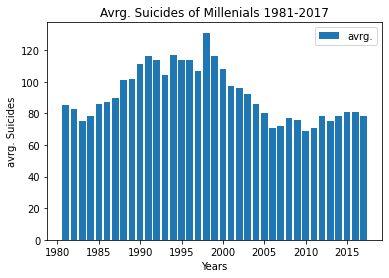

In [ ]:
plt.bar(years, suicides, label="avrg.")
plt.title("Avrg. Suicides of Millenials 1981-2017")
plt.xlabel("Years")
plt.ylabel("avrg. Suicides")
plt.legend()
plt.savefig("./avrg_suicide_data.png")

In [ ]:
def model(years, suicides):
    σ = pyro.param('σ', torch.ones(data_len))
    # Independent events 
    T = pyro.sample('change', dist.Uniform(1981, 2017))
    grp = (years > T) * 1
    with pyro.plate('rate', 2):
        μ = pyro.sample('μ', dist.HalfNormal(scale=50))
    y_obs = pyro.sample('obs', dist.Normal(μ[grp], σ), obs=suicides)

In [ ]:
SAMPLES = 2000
WARMUP = 300

In [ ]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=SAMPLES, warmup_steps=WARMUP)
mcmc.run(years, suicides)

Sample: 100%|██████████| 2300/2300 [53:19,  1.39s/it, step size=2.42e-03, acc. prob=0.982]


In [ ]:
samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    change   1986.89      0.78   1986.59   1986.01   1988.13      4.79      1.26
      μ[0]     82.92      1.21     82.50     81.70     85.66      5.45      1.26
      μ[1]     93.64      0.19     93.64     93.34     93.94    206.19      1.01

Number of divergences: 0


In [ ]:
df = pd.DataFrame() 
df['change'] = samples['change']
df['rate0'] = samples['μ'][..., 0]
df['rate1'] = samples['μ'][..., 1]

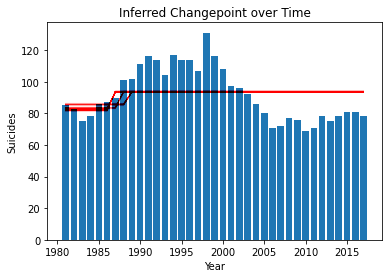

In [ ]:
plt.bar(years, suicides, label='avrg.')
plt.xlabel('Year')
plt.ylabel('Suicides')
plt.title('Inferred Changepoint over Time')

def pl(pt):
    grp = (years > pt['change']) * 1
    line = plt.plot(years, pt['rate0'] * (1 - grp) + pt['rate1'] * grp, 
      color='red', alpha=0.005)    

    
df.apply(pl, axis=1)
plt.savefig("./changepoint_rate_suicides.png")
plt.show()